## Chapter 9 Linear two class classification

# 9.2  The perceptron

In this Section we discuss the *perceptron* - a historically significant and useful way of thinking about linear classification.  The derivation of the perceptron is more direct to the task of classification than is logistic regression, provoking both the use of the *rectified linear unit* function which plays such an important role with neural networks, as well as shedding light on the origin of the *softmax cost function*.  However as we will see the perceptron mindset - combined with our ever-present need for well structured cost functions that we can easily minimize - naturally leads us back to the *softmax cost function* employed by logistic regression.  This shows us that while they are born from different perspectives - in the end - the perceptron and logistic regression are not so different after all.

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# import custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib
datapath = '../../mlrefined_datasets/superlearn_datasets/'

# demos for this notebook
regress_plotter = superlearn.lin_regression_demos
optimizers = optlib.optimizers
static_plotter = superlearn.classification_static_plotter.Visualizer();

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 9.2.1 The perceptron cost function

With two-class classification we have a training set of $P$ points $\left\{ \left(\mathbf{x}_{p},y_{p}\right)\right\} _{p=1}^{P}$ - where $y_p$'s take on just two label values from $\{-1, +1\}$ - consisting of two classes which we would like to learn how to distinguish between automatically.  As we saw in our discussion of logistic regression, in the simplest instance our two classes of data are largely separated by a hyperplane referred to as the *decision boundary* with each class (largely) lying on either side.  Logistic regression determines such a decision boundary by fitting a nonlinear logistic regressor to the dataset, with the separating hyperplane falling out naturally where this logistic function pierces the $y = 0$ plane.  Specifically, we saw how the decision boundary was formally given as a hyperplane

\begin{equation}
\mathbf{x}^{T}\mathbf{w}^{\,} = 0
\end{equation}

where we have used our familiar compact notation (appending a $1$ to the top of each input point)

Using our familiar compact vector notation

\begin{equation}
\mathbf{w}=
\begin{bmatrix}
w_{0}\\
w_{1}\\
w_{2}\\
\vdots\\
w_{N} 
\end{bmatrix}
\,\,\,\,\,\text{and}\,\,\,\,\,\,
\mathbf{x}=
\begin{bmatrix}
1\\
x_{1}\\
x_{2}\\
\vdots\\
x_{N}
\end{bmatrix}.
\end{equation}

In separating the two classes we saw how this implied - when hyperplane parameters $w_0$ and $\mathbf{w}$ were chosen well - that for most points in the dataset, those from class $+1$ lie on the positive side of the hyperplane while those with label $-1$ lie on the negative side of it, i.e.,

\begin{equation}
\begin{array}{cc}
\mathbf{x}_{p}^{T}\mathbf{w}>0 & \,\,\,\,\text{if} \,\,\, y_{p}=+1\\
\mathbf{x}_{p}^{T}\mathbf{w}<0 & \,\,\,\,\text{if} \,\,\, y_{p}=-1
\end{array}
\end{equation}


While the perceptron approach works within the same framework, its approach to determining the decision boundary is more direct.  With the perceptron we aim to directly determine the decision boundary by building a cost function based on these ideal properties, and whose minimum provides optimal weights that reflect these properties as best as possible.  

<figure>
  <img src= '../../mlrefined_images/superlearn_images/Fig_4_1.png' width="80%" height="80%" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> With the perceptron we aim to more directly
 learn the linear decision boundary $\mathbf{x}^{T}\mathbf{w}=0$ (shown
here in black) to separate two classes of data, colored red (class $+1$) and blue (class $-1$), by dividing the input space into a red half-space where $\mathbf{x}^{T}\mathbf{w}>0$,
and a blue half-space where $\mathbf{x}^{T}\mathbf{w}<0$. (left
panel) A linearly separable dataset where it is possible to learn
a hyperplane to perfectly separate the two classes. (right panel)
A dataset with two overlapping classes. Although the distribution
of data does not allow for perfect linear separation, the perceptron still aims to find
a hyperplane that minimizes the number of misclassified points
that end up in the wrong half-space.</em>  </figcaption> 
</figure>

Combining the ideal conditions above - much as we did when deriving how to predict the label value of a point with a trained logistic regressor -  we can consolidate the ideal decision boundary conditions describing both classes below in a single equation as

\begin{equation}
-y_{p}\mathbf{x}_{p}^{T}\mathbf{w}<0
\end{equation}

Notice we can do so specifically because we chose the label values $y_p \in \{-1,+1\}$.  Likewise by taking the maximum of this quantity and zero we can then write this condition, which states that a hyperplane correctly classifies the point $\mathbf{x}_{p}$, equivalently as

\begin{equation}
\text{max}\left(0,\,-y_{p}\mathbf{x}_{p}^{T}\mathbf{w}\right)=0
\end{equation}

Note that the expression $\text{max}\left(0,\,-y_{p}\mathbf{x}_{p}^{T}\mathbf{w}\right)$ is always nonnegative, since it returns zero if $\mathbf{x}_{p}$ is classified correctly, and returns a *positive value* if the
point is classified incorrectly. It is also a *rectified linear unit*  - first discussed in our series on *the basics of mathematical functions* - being the maximum of one quantity and zero.

This expression is useful not only because it characterizes the sort of linear decision boundary we wish to have, but more importantly by simply averaging this over all the points we have the non-negative cost function

\begin{equation}
g\left(\mathbf{w}\right)=\frac{1}{P}\underset{p=1}{\overset{P}{\sum}}\text{max}\left(0,\,-y_{p}\mathbf{x}_{p}^{T}\mathbf{w}\right)
\end{equation}

whose minimum provides the ideal scenario for as many points as possible.  

This cost function goes by many names such as the *perceptron* cost, the *rectified linear unit* cost (or *ReLU cost* for short), and the *hinge cost* (since when plotted a ReLU function looks like a hinge). This cost function is *always convex* but has only a single (discontinuous) derivative in each input dimension. This implies that we can only use gradient descent to minimize it as Newton's method requires a function to have a second derivative as well. Note that the ReLU cost also *always* has a trivial solution at  $\mathbf{w} = \mathbf{0}$, since indeed $g\left(\mathbf{0}\right) = 0$, thus one may need to take care in practice to avoid finding it (or a point too close to it) accidentally.

>  This ReLU cost function is *always convex* but has only a single (discontinuous) derivative in each input dimension, implying that we can only use gradient descent to minimize it. The ReLU cost *always* has a trivial solution at $\mathbf{w} = \mathbf{0}$, since indeed $g\left(\mathbf{0}\right) = 0$, thus one may need to take care in practice to avoid finding it (or a point too close to it) accidentally.

#### <span style="color:#a50e3e;">Example 1: </span> Using gradient descent to minimize the ReLU cost

In this example we use (unnormalized) gradient descent to minimize the ReLU perceptron cost function.  Note however that in examining a partial derivative of just one summand of the cost with respect to weights in $\mathbf{w}$ we have 

\begin{equation}
\frac{\partial}{\partial w_n}  \text{max}\left(0,\,-y_{p}\mathbf{x}_{p}^{T}\mathbf{w}\right)= \begin{cases} -y_p x_{p,n} \,\,\,\text{if} \,\,\, -y_{p}\mathbf{x}_{p}^{T}\mathbf{w}>0 \\ 0 \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \text{else} \end{cases}
\end{equation}

Similarly for $w_0$ we can write

\begin{equation}
\frac{\partial}{\partial w_0}  \text{max}\left(0,\,-y_{p}\mathbf{x}_{p}^{T}\mathbf{w}\right)= \begin{cases} -y_p \,\,\,\,\,\,\,\,\,\,\, \text{if} \,\,\, -y_{p}\mathbf{x}_{p}^{T}\mathbf{w}>0 \\ 0 \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \text{else} \end{cases}
\end{equation}

We can then conclude the magnitude of the full cost function's gradient will not necessarily diminish to zero close to global minima and could stay fixed (in magnitude) based on the dataset. Thus, it is possible for gradient descent with a fixed steplength value $\alpha$ to oscillate and 'zig-zag' around, never going to a minimum (as detailed in our series on *mathematical optimization*). In this case we need to either tune a fixed steplength or choose a diminishing one.

In the next ``Python`` cell we load in one of the datasets originally introduced in the previous Section on logistic regression.

In [5]:
# load in dataset
data = np.loadtxt(datapath + '3d_classification_data_v0.csv',delimiter = ',')

# get input/output pairs
x = data[:,:-1:].T
y = data[:,-1:] 

Next, we implement the ReLU cost function in ``Python``.  Notice we have implemented it using efficient ``numpy`` operations instead of explicit ``for`` loops.  We also have a similarly efficient implementation of the counting cost function, described in the previous Section, used for counting the number of misclassifications for a given set of weights. 

In [8]:
# compute linear combination of input point
def model(x,w):
    # tack a 1 onto the top of each input point all at once
    o = np.ones((1,np.shape(x)[1]))
    x = np.vstack((o,x))
    
    # compute linear combination and return
    a = np.dot(x.T,w)
    return a

# the convex relu cost function
def relu(w):
    cost = np.sum(np.maximum(0,-y*model(x,w)))
    return cost/float(len(y))

# the counting cost function
def counting_cost(w):
    cost = np.sum((np.sign(model(x,w)) - y)**2)
    return 0.25*cost 

Then, we make a few runs of gradient descent run of 50 steps, randomly initialized, with two step length choices, picking the best of those runs to then use for our final classifier.

In [9]:
# run gradient descent to minimize the perceptron cost
g = relu; w = 0.1*np.random.randn(3,1); max_its = 200; 
alpha_choice = 10**(-1)

weight_history_1,cost_history_1 = optimizers.gradient_descent(g,alpha_choice,max_its,w)
count_history_1 = [counting_cost(v) for v in weight_history_1]

alpha_choice = 10**(-2)
weight_history_2,cost_history_2 = optimizers.gradient_descent(g,alpha_choice,max_its,w)
count_history_2 = [counting_cost(v) for v in weight_history_2]

<IPython.core.display.Javascript object>


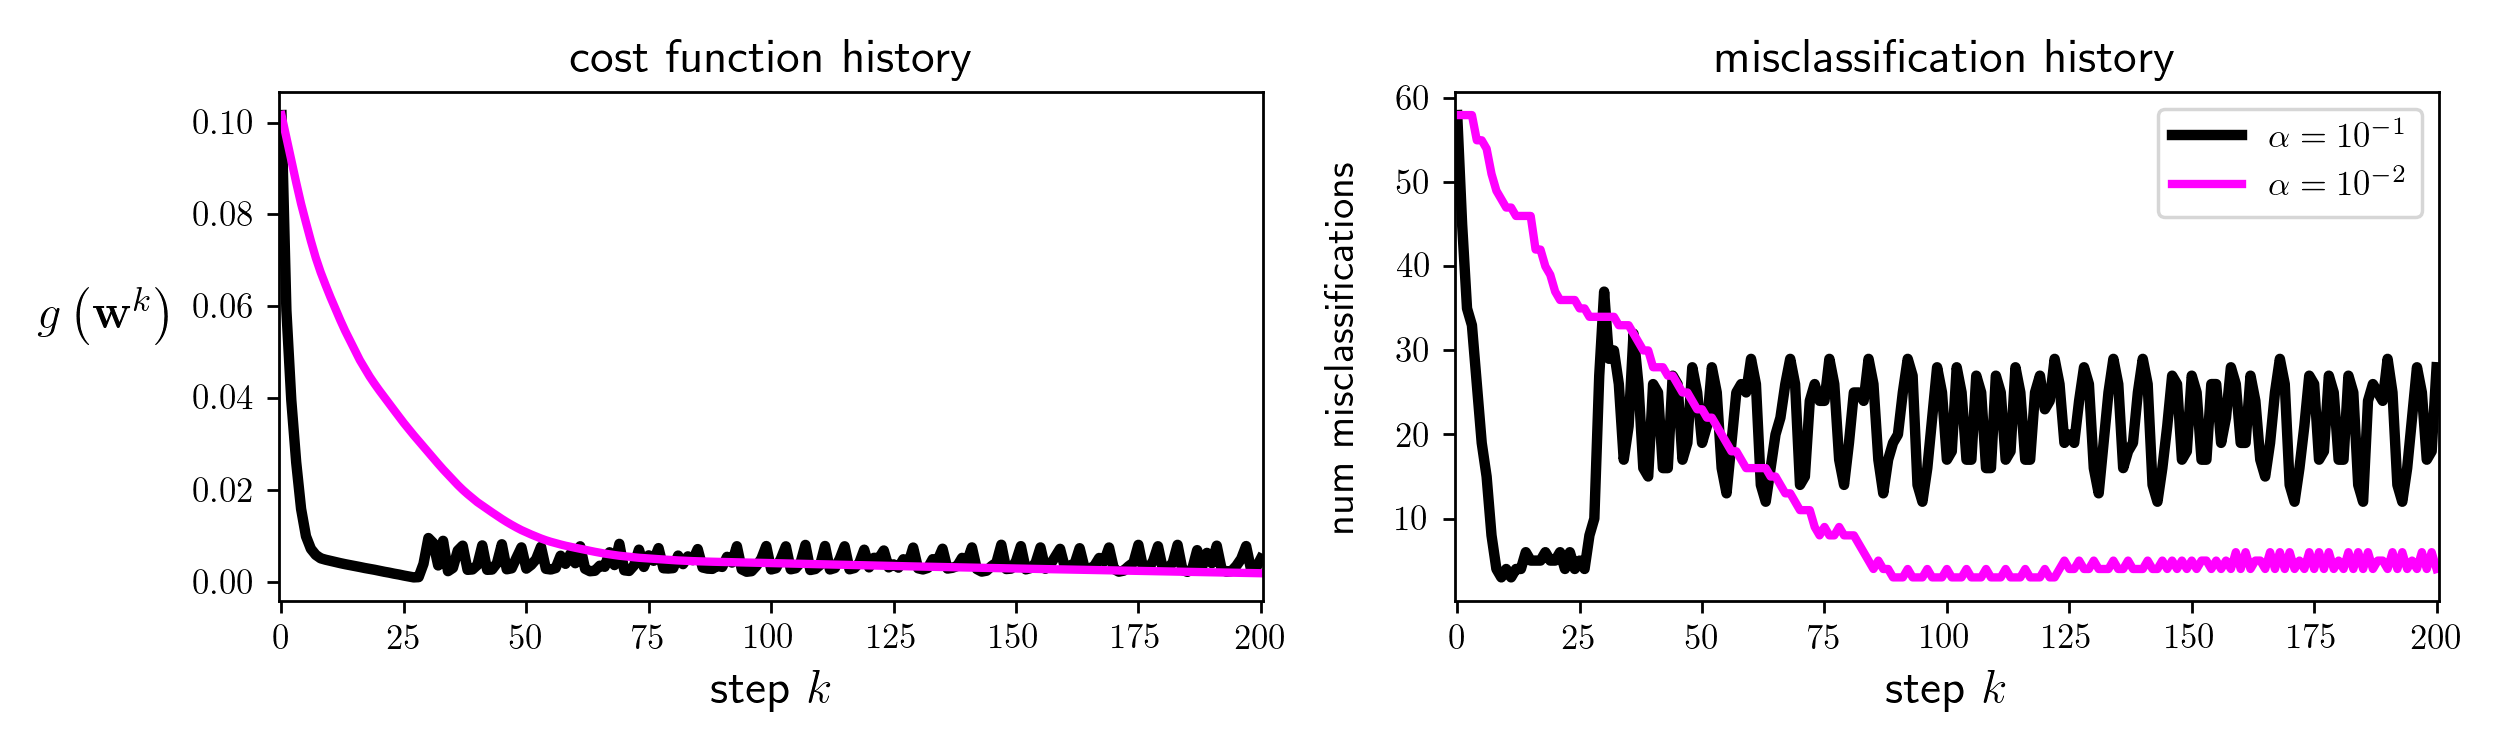

In [10]:
# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history_1,cost_history_2],[count_history_1,count_history_2],start = 0,labels = [r'$\alpha = 10^{-1}$',r'$\alpha = 10^{-2}$'])

Examining the misclassification histories in the right hand panel, the choice of $\alpha = 10^{-2}$ produces the best result.  Moreover it looks like the best weights - those providing the smallest number of misclassifications - occurs around iteration $25$.  We pull out this set of weights below.

In [11]:
# pull best set of weights given misclassification history
ind = np.argmin(count_history_2)
w_best = weight_history_2[ind]

Finally, we plot the dataset and learned decision boundary $\mathbf{x}^{T}\mathbf{w}^{\star} = 0
$ in the ``Python`` cell below. 

<IPython.core.display.Javascript object>


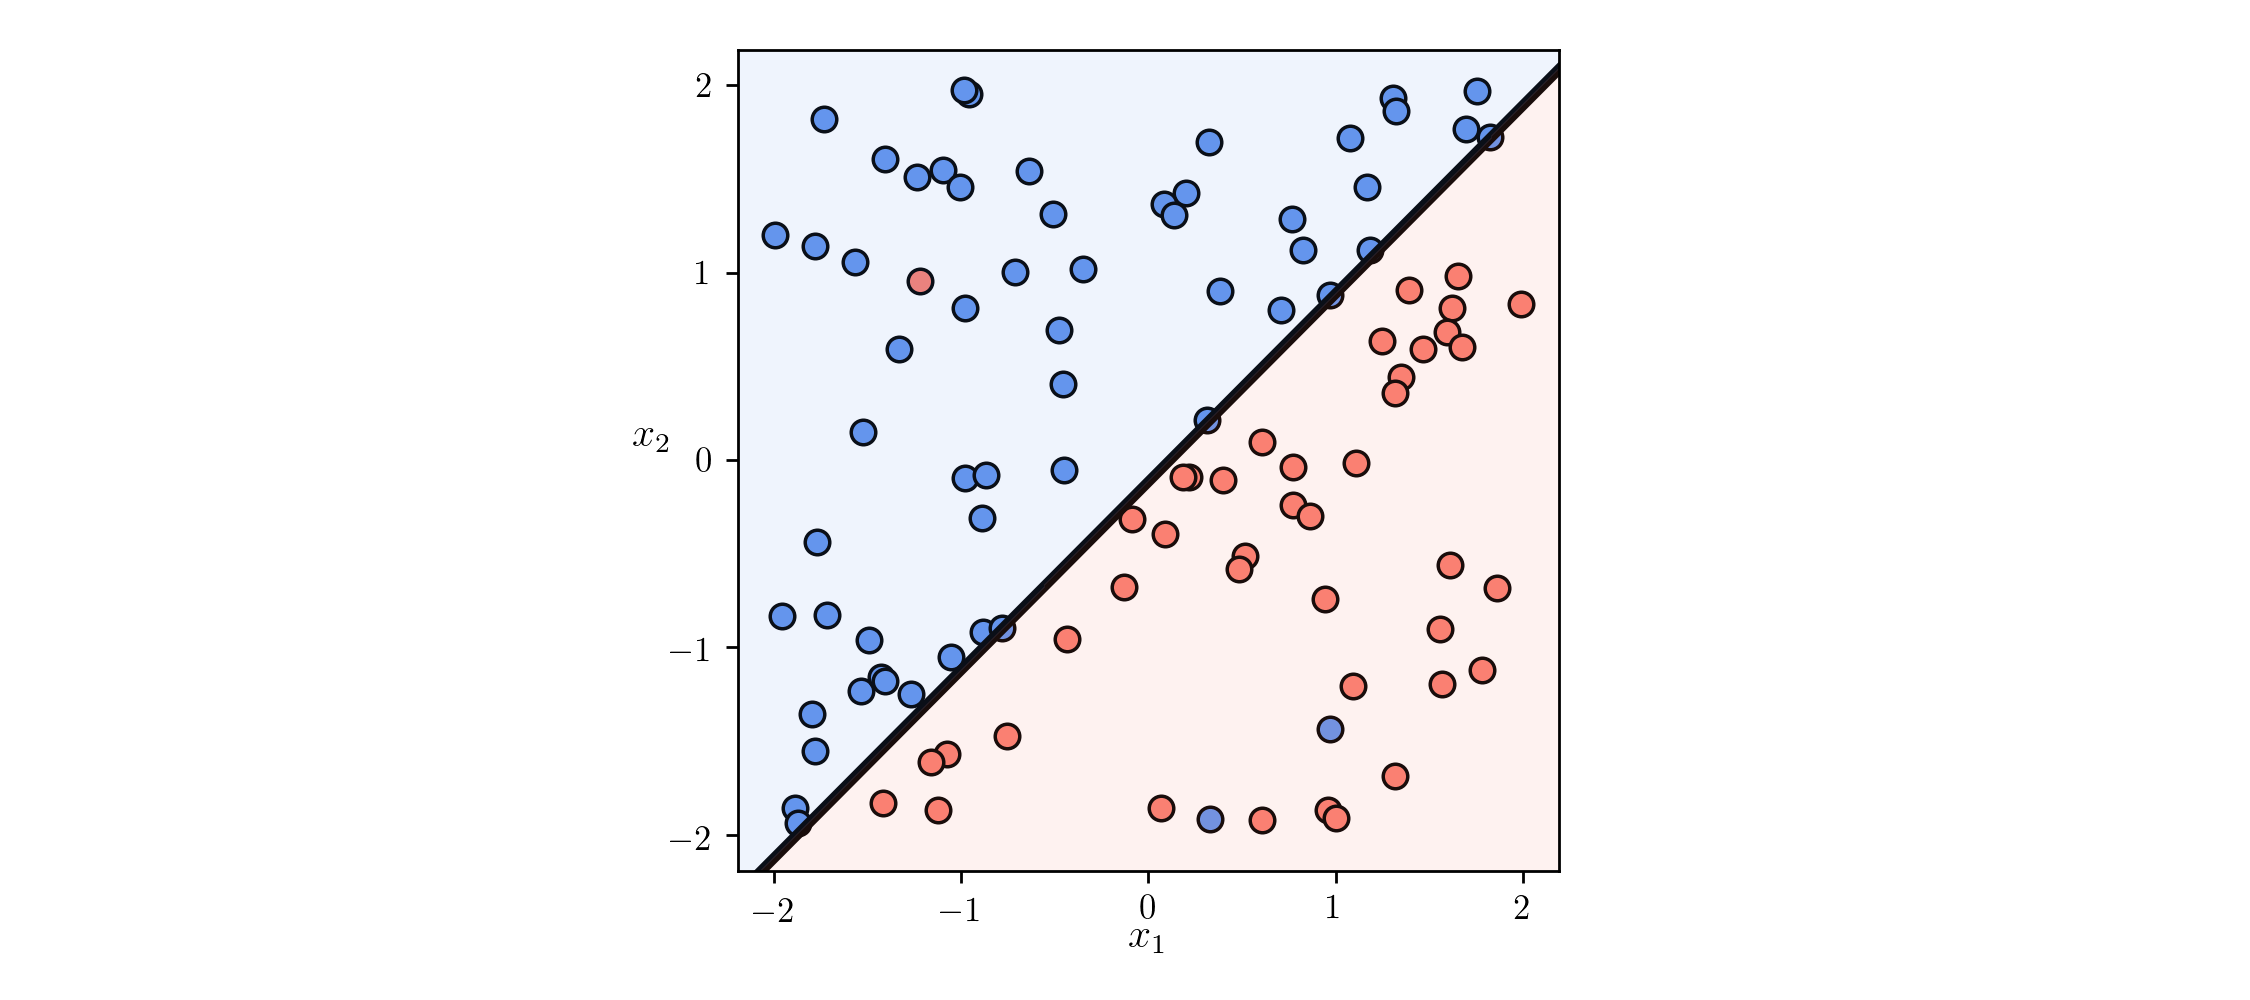

In [12]:
# create instance of 3d demos
demo = superlearn.classification_3d_demos.Visualizer(data)

# draw the final results
demo.static_fig_topview(g,w_best)

## 9.2.2  The smooth softmax approximation to the ReLU perceptron cost

Learning and optimization go hand in hand, and as we know from the discussion above the ReLU function limits the number of optimization tools we can bring to bear for learning. It not only prohibits the use of Newton's method but forces us to be very careful about how we choose our steplength parameter $\alpha$ with gradient descent as well. Here we describe a common approach to ameliorating this issue by introducing a smooth approximation to this cost function. This practical idea takes many forms depending on the cost function at play, but the general idea is this: when dealing with a cost function that has some deficit (insofar as mathematical optimization is concerned) replace it with a  smooth (or at least twice differentiable) cost function that closely matches it everywhere. If the approximation closely matches the true cost function then for the small amount of accuracy (we will after all be minimizing the approximation, not the true function itself) we significantly broaden the set of optimization tools we can use.

One popular way of doing this for the ReLU cost function is via the *softmax* function defined as


\begin{equation}
\text{soft}\left(s_1,s_2,...,s_N\right) = \text{log}\left(e^{s_1} + e^{s_2} + \cdots + e^{s_N} \right)
\end{equation}

which is a generic smooth approximation to the *max* function, i.e., 

\begin{equation}
\text{soft}\left(s_1,s_2,...,s_N\right) \approx \text{max}\left(s_1,s_2,...,s_N\right)
\end{equation}

To see why the softmax approximates the max function let us look at the simple case when $N = 2$. 

Suppose momentarily that $s_{1}\leq s_{2}$, so that $\mbox{max}\left(s_{1},\,s_{2}\right)=s_{2}$.  Therefore $\mbox{max}\left(s_{1},\,s_{2}\right)$ can be written as $\mbox{max}\left(s_{1},\,s_{2}\right)=s_{1}+\left(s_{2}-s_{1}\right)$,
or equivalently as $\mbox{max}\left(s_{1},\,s_{2}\right)=\mbox{log}\left(e^{s_{1}}\right)+\mbox{log}\left(e^{s_{2}-s_{1}}\right)$. Written in this
way we can see that $\mbox{log}\left(e^{s_{1}}\right)+\mbox{log}\left(1+e^{s_{2} s_{1}}\right)=\mbox{log}\left(e^{s_{1}}+e^{s_{2}}\right)=\mbox{soft}\left(s_{1},s_{2}\right)$ is always larger than $\mbox{max}\left(s_{1},\,s_{2}\right)$ but not by much, especially when $e^{s_{2}-s_{1}}\gg1$. Since the same argument can be made if $s_{1}\geq s_{2}$ we can say generally that
$ $$\mbox{soft}\left(s_{1},s_{2}\right)\approx\mbox{max}\left(s_{1},s_{2}\right)$.  The more general case follows similarly as well.

<figure>
  <img src= '../../mlrefined_images/superlearn_images/Fig_4_2.png' width="50%" height="auto"/>
  <figcaption>   
<strong>Figure 2:</strong> <em> 
    Plots of the non-differentiable
perceptron or hinge cost $g\left(s\right)=\mbox{max}\left(0,\,s\right)$
(shown in green) as well as its smooth softmax approximation $g\left(s\right)=\mbox{soft}\left(0,\,s\right)=\mbox{log}\left(1+e^{s}\right)$
(shown in dashed black).
    </em>  </figcaption> 
</figure>

Returning to the ReLU perceptron cost function in equation (5), we replace the $p^{th}$ summand with its softmax approximation

\begin{equation}
\text{soft}\left(0,\,-y_{p}\mathbf{x}_{p}^{T}\mathbf{w}\right)= \text{log}\left(e^{0} + e^{-y_{p}\mathbf{x}_{p}^{T}\mathbf{w}}\right) = \text{log}\left(1 + e^{-y_{p}\mathbf{x}_{p}^{T}\mathbf{w}}\right)
\end{equation}

giving the overall cost function as 

\begin{equation}
g\left(\mathbf{w}\right)=\underset{p=1}{\overset{P}{\sum}}\text{log}\left(1 + e^{-y_{p}\mathbf{x}_{p}^{T}\mathbf{w}}\right)
\end{equation}

which is the *softmax cost* we saw previously derived from the logistic regression perspective on two-class classification.  This is why the cost is called *softmax*, since it derives from the general softmax approximation to the max function.

Note that *like* the ReLU cost - as we already know - the softmax cost is convex. However *unlike* the ReLU cost, the softmax has infinitely many derivatives and Newton's method can therefore be used to minimize it. Moreover, softmax does not have a trivial solution at zero like the ReLU cost does. On the other hand as we have seen previously, the softmax cost can have a solution at infinity (when the data is perfectly separable) which can present its own numerical challenges.

Nonetheless, the fact that the softmax cost so closely approximates the ReLU shows just how closely aligned - in the end - both logistic regression and the perceptron truly are. Practically speaking their differences lie in how well - for a particular dataset - one can optimize either one, along with (what is very often slight) differences in the quality of each cost function's learned decision boundary.